# Indeed.com scraping with Selenium and BeautifulSoup

In [1]:
# import packages
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
from selenium import webdriver
import time
from datetime import datetime

- In the url, delete the job title and location, and replace it with curly braces. 
- Create a base_url that you'll use to create whatever job position or location that you want.

In [2]:
base_url = 'https://nl.indeed.com/jobs?q={}&l={}&start='

- Create a function called get_url, with the arguments of position and location. Then move the base_url variable inside this function.

In [3]:
def get_url(position, location):
    """Generate a url from position and location"""
    base_url = 'https://nl.indeed.com/jobs?q={}&l={}&start='
    url = base_url.format(position, location)
    return url

- Fill in your desired position and location

In [4]:
url = get_url('data analist', 'Nederland')

In [5]:
# check
url

'https://nl.indeed.com/jobs?q=data analist&l=Nederland&start='

In [8]:
# create driver object
driver = webdriver.Chrome()
time.sleep(10)

### Access the site programmatically

- Tell the browser to visit the indeed page. Call the driver object created above and use the get method; pass the URL of the website you'd like to extract.

In [9]:
# asses webpage
driver.get(url)

- Accept cookies, if applicable.

In [10]:
try:
    driver.find_element_by_id('onetrust-accept-btn-handler').click()
    time.sleep(2)
except:
    print('probably accepted the cookie already!')

- Use BeautifulSoup; create the res object from the driver object.

In [11]:
res = driver.page_source.encode('utf-8')
soup = BeautifulSoup(res, "html.parser")

In [12]:
# store job card links in list
jobs = driver.find_elements_by_class_name('jobsearch-SerpJobCard')

# check
jobs

[<selenium.webdriver.remote.webelement.WebElement (session="7177190f3dba7e6394ecc5ad1dbe7d39", element="0.17931945507788227-2")>,
 <selenium.webdriver.remote.webelement.WebElement (session="7177190f3dba7e6394ecc5ad1dbe7d39", element="0.17931945507788227-3")>,
 <selenium.webdriver.remote.webelement.WebElement (session="7177190f3dba7e6394ecc5ad1dbe7d39", element="0.17931945507788227-4")>,
 <selenium.webdriver.remote.webelement.WebElement (session="7177190f3dba7e6394ecc5ad1dbe7d39", element="0.17931945507788227-5")>,
 <selenium.webdriver.remote.webelement.WebElement (session="7177190f3dba7e6394ecc5ad1dbe7d39", element="0.17931945507788227-6")>,
 <selenium.webdriver.remote.webelement.WebElement (session="7177190f3dba7e6394ecc5ad1dbe7d39", element="0.17931945507788227-7")>,
 <selenium.webdriver.remote.webelement.WebElement (session="7177190f3dba7e6394ecc5ad1dbe7d39", element="0.17931945507788227-8")>,
 <selenium.webdriver.remote.webelement.WebElement (session="7177190f3dba7e6394ecc5ad1dbe7d

## There might be 3 alternatives to collect the data

- Each have advantages and disadvantages in terms of collection time and quality of data collected
- Here is a brief illustration of each alternative

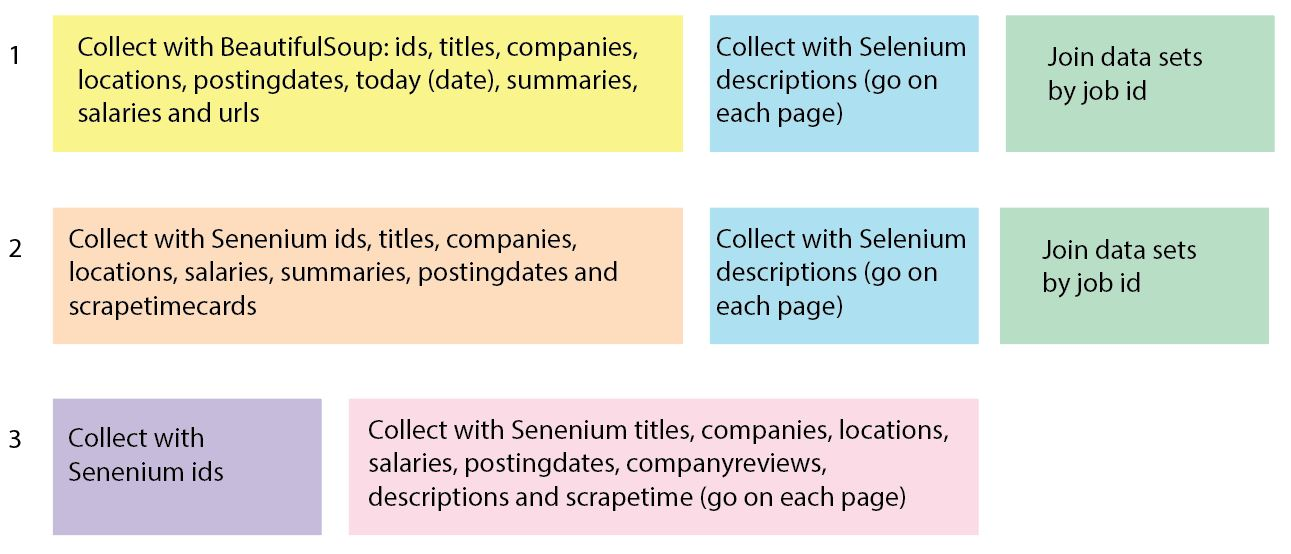

In [6]:
from IPython.display import Image
Image(filename='3_alternatives.jpg')

# Alternative #1

- Use BeautifulSoup to collect, for each job card: id, title, company, location, postingdate, today (date), summary, salary and url.
- Use Selenium to loop with the ids through the pages and collect the description.
- Join the two datasets based on the id column
- Advantages of this alternative: you get all the proper information from the job cards, and you enhance that data with the job descriptions collected separately.
- Disadvantage: not everything is run in one go, and you have to put it together later on.

In [13]:
cards = soup.find_all('div', 'jobsearch-SerpJobCard')

- Create a function called get_record, which will accept a single argument card.

In [14]:
def get_record(card):
    """Extract job data from a single record"""
    id = card.find('div', 'recJobLoc').get('id').split('_')[1]
    atag = card.h2.a
    title = atag.get('title')
    url = 'https://nl.indeed.com' + atag.get('href')
    company = card.find('span', 'company').text.strip()
    location = card.find('div', 'recJobLoc').get('data-rc-loc')
    summary = card.find('div', 'summary').text.strip()
    postingdate = card.find('span', 'date').text
    today = datetime.today().strftime('%Y-%m-%d')
    try:
        salary = card.find('span', 'salaryText').text.strip()
    except AttributeError:
        salary = ''
        
    record = {'id':id, 'title':title, 'company':company, 'location':location,
              'postingdate':postingdate, 'today':today, 'summary':summary,
              'salary':salary, 'url':url}
    
    return record

- Create a list called records. Then, iterate through each card, extracting the record from the card data and then appending that extracted data to the records list.

In [15]:
records = []

while True:
    try:
        url = 'https://nl.indeed.com' + soup.find('a',{'aria-label': 'Volgende'}).get('href')
    except AttributeError:
        break
    
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    cards = soup.find_all('div', 'jobsearch-SerpJobCard')
    
    for card in cards:
        record = get_record(card)
        records.append(record)

In [16]:
len(records)

1274

In [18]:
# create data frame
cols = list(records[0].keys())

postings_df = pd.DataFrame(columns=cols)
for record in records:
    postings_df = postings_df.append(record, ignore_index=True)

In [19]:
# check if works
postings_df.head()

,id,title,company,location,postingdate,today,summary,salary,url
0,b80883159b35a0d4,Data Analyst,Luxoft,Werk van thuis,1 dag geleden,2021-03-13,O Reconcile PSPs (Payment Service Providers) a...,,https://nl.indeed.com/rc/clk?jk=b80883159b35a0...
1,6f88c3b37ffc3fad,Data analist,Tempo-Team,Son,11 dagen geleden,2021-03-13,Voor de afdeling Supply Chain zoeken zij een d...,€2.800 - €3.200 per maand,https://nl.indeed.com/rc/clk?jk=6f88c3b37ffc3f...
2,6a28b29568a5595a,Data Analist,Gemeente Rotterdam,Rotterdam,2 dagen geleden,2021-03-13,De data analist wordt rechtstreeks aangestuurd...,€2.973 - €4.494 per maand,https://nl.indeed.com/rc/clk?jk=6a28b29568a559...
3,7274afb03aaa40d4,Data Analist Commercie,Albert Heijn,Zaandam,Vandaag,2021-03-13,"Een data-gedreven organisatie, waar de stakeho...",,https://nl.indeed.com/rc/clk?jk=7274afb03aaa40...
4,07b0178cd8c65029,Informatiemanager / Business Analist,Fontys,Eindhoven,Meer dan 30 dagen geleden,2021-03-13,Als informatiemanager / business analist voor ...,€4.445 - €5.717 per maand,https://nl.indeed.com/rc/clk?jk=07b0178cd8c650...


In [20]:
# export data frame to csv
postings_df.to_csv('postings.csv')

- Use Selenium to collect the job descriptions from each job page.

In [29]:
descriptions = []
scrapetimesdescriptions = []

#Use this just for scraping a sample: jobids2 = postings_df['id'][:3]
start = 0
end = 10
jobids2 = postings_df['id'][start:end]

for jobid in jobids2:
    driver.get('https://nl.indeed.com/vacature-bekijken?jk='+jobid)
    scrapetimesdescriptions.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    time.sleep(3)
    try:
        descriptions.append(driver.find_element_by_id('jobDescriptionText').text.replace('\n',' '))
    except:
        descriptions.append('')

In [30]:
#create data frame
descriptions_alternative1 = pd.DataFrame(index=jobids2, data={'description':descriptions, 'scrapetimesdescription':scrapetimesdescriptions})

In [31]:
# export data frame to csv
descriptions_alternative1.to_csv('descriptions_alternative1_{}_{}.csv'.format(str(start), str(end)))

# Alternative #2

- Loop through the pages and collect from the current page the ids, titles, companies, locations, salaries, summaries, postingdates and scrapetimecards
- Then use the ids to access the pages and collect the descriptions
- Join the two datasets by the id column
- Advantage: you only use Selenium, so you are more consistent
- Disadvantage: 1) many elements of most of the lists you create are returned empty; lists such as titles, companies, locations, postingdates and salaries (this is not a problem like the other exampes, because it was already expected to contain missing data, as not all companies provide a salary range). 2) It takes a long time to scrape and only in the end you can assess the magnitude of the missing data. As such, this may be a less preferred alternative.

In [32]:
jobids = []
titles = []
companies = []
locations = []
salaries = []
summaries = []
postingdates = []
scrapetimecards = []

# loop through first 80 pages
for i in range(0,800,10):
    driver.get(url+str(i))
    time.sleep(3)
    jobs = driver.find_elements_by_class_name('jobsearch-SerpJobCard')
    time.sleep(3)
    
    # collect elements from current page
    for job in jobs:        
        try:
            jobids.append(job.get_attribute('data-jk'))
        except:
            jobids.append('')
        try:
            titles.append(job.find_element_by_class_name('title').text)
        except:
            titles.append('')
        try:
            companies.append(job.find_element_by_class_name('company').text)
        except:
            companies.append('')
        try:
            locations.append(job.find_element_by_class_name('location').text)
        except:
            locations.append('')
        try:
            salaries.append(job.find_element_by_class_name('salaryText').text)
        except:
            salaries.append('')
        try:
            summaries.append(job.find_element_by_class_name('summary').text)
        except:
            summaries.append('')
        try:
            postingdates.append(job.find_element_by_class_name('date').text)
        except:
            postingdates.append('')
        scrapetimecards.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

### Create a data frame from the above lists

In [34]:
#create data frame
postings_alternative2 = pd.DataFrame(index=jobids, data={'title':titles,
                        'company':companies, 'location':locations, 'salary':salaries,
                        'summary':summaries, 'postingdate':postingdates,
                        'scrapetimecard':scrapetimecards})


In [35]:
# save
postings_alternative2.to_csv('postings_alternative2.csv')

In [38]:
descriptions = []
scrapetime = []

#Use this just for scraping a sample: jobids2 = jobids[start:end]
start = 0
end = 10
jobids2 = jobids[start:end]

for jobid in jobids2:
    driver.get('https://nl.indeed.com/vacature-bekijken?jk='+jobid)
    scrapetime.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    time.sleep(3)
    try:
        descriptions.append(driver.find_element_by_id('jobDescriptionText').text.replace('\n',' '))
    except:
        descriptions.append('')


In [39]:
#create data frame
descriptions = pd.DataFrame(index=jobids2, data={'description':descriptions, 'scrapetime':scrapetime})

In [41]:
# export data frame to csv
descriptions.to_csv('descriptions_alternative2_{}_{}.csv'.format(str(start), str(end)))

# Alternative #3

- Loop through the pages and collect the ids from the current page
- Use the ids to access each page and collect: titles, companies, locations, salaries, postingdates, companyreviews, descriptions and scrapetime.
- Advantage: you collect everything in one go
- Disadvantage: 1) the location is difficult to be captured on the page, and so that collumn contains random information, such as company reviews. 2) It takes a long time to scrape and only in the end you can assess the magnitude of the missing data.

## Loop through the pages and collect the ids from the current page

In [42]:
jobids = []

# loop through first 80 pages
for i in range(0,80,10):
    driver.get(url+str(i))
    time.sleep(6)
    jobs = driver.find_elements_by_class_name('jobsearch-SerpJobCard')
    
    # collect ids from current page
    for job in jobs:
        jobid = job.get_attribute('data-jk')
        jobids.append(jobid)

In [43]:
# check first 20 ids
jobids[:20]

['db8dcef67ff3924b',
 '9023f99261818767',
 'e74ce4fe3e006945',
 '6ec175cc130e75c7',
 '63f98e1d100267f5',
 '7385ee546a888d20',
 '087e0562ec8c2279',
 '552907c21ef1df3c',
 '514c29742f04694e',
 '27964f165332d2b5',
 'c5def3fa80154e8d',
 '7f6a60b1dc02e185',
 '950208113343964f',
 '9aab95dcb4133af2',
 '72702b485ef6452e']

## Check all components separately with one job id

### Get the job title

In [44]:
driver.get('https://nl.indeed.com/vacature-bekijken?jk=024641b602f7096c')
time.sleep(5)
title = driver.find_element_by_class_name('jobsearch-JobInfoHeader-title').text

# check
title

'Data Analist'

### Get the job company

In [45]:
driver.get('https://nl.indeed.com/vacature-bekijken?jk=024641b602f7096c')
time.sleep(5)
company = driver.find_element_by_class_name('jobsearch-InlineCompanyRating').text

# check
company

'Aon\n4,609 reviews'

### Get the job salary

In [46]:
driver.get('https://nl.indeed.com/vacature-bekijken?jk=024641b602f7096c')
time.sleep(5)
try:
    salary = driver.find_element_by_class_name('jobsearch-JobMetadataHeader-item').text
except:
    salary = ""

# check
salary

'€2.600 - €3.500 per maand'

### Get the job location

In [48]:
driver.get('https://nl.indeed.com/vacature-bekijken?jk=024641b602f7096c')
time.sleep(5)
location = driver.find_element_by_class_name('jobsearch-DesktopStickyContainer-subtitle').text#.splitlines()[1]

# check
location

'Aon\n4,609 reviews\nPostcode 5651 in Eindhoven'

### Get the job company review

In [49]:
driver.get('https://nl.indeed.com/vacature-bekijken?jk=024641b602f7096c')
time.sleep(5)
companyreview = driver.find_element_by_class_name('jobsearch-CompanyReview').find_element_by_class_name('icl-Ratings-count').text

# check
companyreview

''

### Get the job description

In [50]:
driver.get('https://nl.indeed.com/vacature-bekijken?jk=024641b602f7096c')
time.sleep(5)
description = driver.find_element_by_id('jobDescriptionText').text.replace('\n',' ')

# check
description

'Over deze vacature In het kort Ben je analytisch sterk en altijd op zoek naar mogelijkheden om te helpen bij het verwezenlijken van bedrijfsdoelstellingen? Wil jij continu het beste halen uit data en met het team om tafel voor de beste strategie? Dan is de functie van Data Analist zeker iets voor jou! Jij brengt mee Minimaal hbo werk- en denkniveau Sterke affiniteit met processen en IT Grote mate van zelfstandigheid en daadkracht Je vindt bij ons Vaste 13e maand Bonusregeling Premievrij pensioen Tom von Wolzogen Kühr Recruiter 06 22581665  tom.von.wolzogen.kuhr@aon.com  linkedin.com/in/tomvonwolzogenkühr Wat ga je doen? Met de toenemende groei van data is de behoefte naar goede informatie en het gebruik en interpreteren daarvan explosief gestegen. Data is dan ook één van de internationale pijlers binnen Aon. Als Data Analist krijg je de ruimte om te pionieren. Je geeft proactief inzicht in het gedrag van onze klanten, identificeer en kwantificeer je risico’s, signaleer je trends en on

### Get the job posting date

In [51]:
driver.get('https://nl.indeed.com/vacature-bekijken?jk=024641b602f7096c')
time.sleep(5)
postingdate = driver.find_element_by_class_name('jobsearch-JobMetadataFooter').text.splitlines()[1]

# check
postingdate

'30+ dagen geleden'

# Putting it all together

- Note: if it asks you at some point to prove that you're not a robot, copy the link in a new window and select the right images.
- Tip for the the next trial: separate the ids in multiple bundles and run them separately to ensure that it doens't crush.

In [52]:
titles = []
companies = []
locations = []
salaries = []
postingdates = []
companyreviews = []
descriptions = []
scrapetime = []

#Use this just for scraping a sample: jobids2 = jobids[start:end]
start = 0
end = 10
jobids2 = jobids[start:end]


for jobid in jobids2:
    driver.get('https://nl.indeed.com/vacature-bekijken?jk='+jobid)
    scrapetime.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    time.sleep(3)
    try:
        titles.append(driver.find_element_by_class_name('jobsearch-JobInfoHeader-title').text)
    except:
        titles.append('')
    try:
        companies.append(driver.find_element_by_class_name('jobsearch-InlineCompanyRating').text)
    except:
        companies.append('')
    try:
        locations.append(driver.find_element_by_class_name('jobsearch-DesktopStickyContainer-subtitle').text.splitlines()[1])
    except:
        locations.append('')
    try:
        salaries.append(driver.find_element_by_class_name('jobsearch-JobMetadataHeader-item').text)
    except:
        salaries.append('')
    try:
        postingdates.append(driver.find_element_by_class_name('jobsearch-JobMetadataFooter').text.splitlines()[1])
    except:
        postingdates.append('')
    try:
        companyreviews.append(driver.find_element_by_class_name('jobsearch-CompanyReview').find_element_by_class_name('icl-Ratings-count').text)
    except:
        companyreviews.append('')
    try:
        descriptions.append(driver.find_element_by_id('jobDescriptionText').text.replace('\n',' '))
    except:
        descriptions.append('')

### Create a data frame from the above lists

In [53]:
jobdata = pd.DataFrame(index=jobids2, data={'title':titles, 'company':companies, 'location':locations,
                                            'salary':salaries, 'postingdate':postingdates,
                                            'companyreview':companyreviews, 'description':descriptions,
                                           'scrapetime':scrapetime})

In [54]:
# check
jobdata

,title,company,location,salary,postingdate,companyreview,description,scrapetime
db8dcef67ff3924b,Specialist Product Planning,Hoshizaki,Postcode 1101 in Amsterdam-Zuidoost,,30+ dagen geleden,,Hoshizaki is a leading manufacturer of commerc...,2021-03-13 16:25:45
9023f99261818767,Compensation Operations Manager,"Adecco\n17,764 reviews","17,764 reviews",,8 dagen geleden,,Do you have experience in Compensation and lea...,2021-03-13 16:25:49
e74ce4fe3e006945,Feedstock Development Manager,Argent Energy Netherlands Holding B.V.,Postcode 1044 in Amsterdam Westpoort,Voltijds,Vandaag,,Working at Argent Energy is an opportunity to ...,2021-03-13 16:25:53


### Save the data frame in a csv file

In [56]:
# save
jobdata.to_csv('postings_alternative3_{}_{}.csv'.format(str(start), str(end)))

## To do

- If possible, tackle the Captcha